In [179]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, plot_confusion_matrix, precision_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import xgboost as xgb
from xgboost import plot_importance

import string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

from wordcloud import WordCloud, STOPWORDS

import pickle

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
df = pd.read_csv('csv_files/job_post_dataframe.csv', index_col=0)

In [11]:
df.head()

,languages,overview,position_title,clean_description,target
1,"['amazon-web-services', 'python', 'docker', 'k...",Paige is a software company helping pathologis...,Senior Software Engineer Backend Cloud Computing,Job type Full time Experience level Senior Rol...,1
3,"['python', 'javascript', 'reactjs', 'django', ...",About UsSimon Data was founded in by a team of...,Engineering Manager,Job type Full time Experience level Senior Man...,1
4,"['node.js', 'kubernetes', 'microservices', 'ty...",Who is MANTL MANTL is a fast growing NYC based...,Senior Backend Engineer NYC Or Remote,Job type Full time Experience level Mid Level ...,0
5,"['api', 'postgresql', 'scala', 'amazon-web-ser...",As a SIMON Backend Engineer you will play an i...,Backend Engineer,Job type Full time Experience level Mid Level ...,0
6,"['go', 'ruby', 'ruby-on-rails', 'redis', 'post...",Gravity is looking for passionate software eng...,Software Engineer Backend NYC/LA,Job type Full time Experience level Junior Mid...,0


In [13]:
# appear to have been nan values, so i dropped the rows with them
df.dropna(subset=['overview'], inplace=True)

In [14]:
# specifying feature and target variables
X = df['overview']
y = df['target']

In [15]:
# creating a list of stopwords 
stopwords_list = stopwords.words('english') + list(string.punctuation)

# initalizing test-train split

In [17]:
# initializing test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
tf = TfidfVectorizer(stop_words = stopwords_list)  
tf_idf_train = tf.fit_transform(X_train)
tf_idf_test = tf.transform(X_test)

# Establishing SMOTE and ADASYN for the data

In [36]:
smt = SMOTE(sampling_strategy='minority')
X_train_smt, y_train_smt = smt.fit_sample(tf_idf_train, y_train)

In [35]:
ada = ADASYN(sampling_strategy='minority')
X_train_ada, y_train_ada = ada.fit_sample(tf_idf_train, y_train)

In [221]:
# with open('balanced_train', 'wb') as handle:
#     pickle.dump(y_train_ada, handle, protocol=pickle.HIGHEST_PROTOCOL)

# creating dummy classifier

In [37]:
# dummy for unbalanced data
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(tf_idf_train, y_train)

# dummy for SMOTE data
dummy_clf_smt = DummyClassifier(strategy='most_frequent')
dummy_clf_smt.fit(X_train_smt, y_train_smt)

# dummy for ADASYN data
dummy_clf_ada = DummyClassifier(strategy='most_frequent')
dummy_clf_ada.fit(X_train_ada, y_train_ada)

DummyClassifier(strategy='most_frequent')

In [38]:
dummy_preds = dummy_clf.predict(tf_idf_test)
dummy_preds_smt = dummy_clf_smt.predict(tf_idf_test)
dummy_preds_ada = dummy_clf_ada.predict(tf_idf_test)

In [278]:
print('Dummy Classifier Accuracy Score: ',accuracy_score(y_test, dummy_preds))
print('Dummy Classifier F1 Score: ',f1_score(y_test, dummy_preds))

Dummy Classifier Accuracy Score:  0.8330019880715706
Dummy Classifier F1 Score:  0.0


In [279]:
print('ADA Dummy Classifier Accuracy Score: ',accuracy_score(y_test, dummy_preds_ada))
print('ADA Dummy Classifier F1 Score: ',f1_score(y_test, dummy_preds_ada))

ADA Dummy Classifier Accuracy Score:  0.8330019880715706
ADA Dummy Classifier F1 Score:  0.0


In [280]:
print('SMT Dummy Classifier Accuracy Score: ',accuracy_score(y_test, dummy_preds_smt))
print('SMT Dummy Classifier F1 Score: ',f1_score(y_test, dummy_preds_smt))

SMT Dummy Classifier Accuracy Score:  0.8330019880715706
SMT Dummy Classifier F1 Score:  0.0


# Setting up Gridsearch for Naives Bayes

In [115]:
# creating dictionaries for naive bayes gridsearch parameters
nb_param = {'alpha':[0.0001, 0.001, 0.01, 0.05, 0.1]}

In [134]:
grid_nb = GridSearchCV(nb_classifier, nb_param, n_jobs = -1, cv =5, verbose =1)

grid_nb.fit(tf_idf_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.9s finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1]}, verbose=1)

In [135]:
grid_nb.best_params_

{'alpha': 0.0001}

In [281]:
grid_nb_pred = grid_nb.best_estimator_.predict(tf_idf_test)

print('Gridsearch NB Accuracy SCore: ',accuracy_score(grid_nb_pred, y_test))
print('Gridsearch NB F1 SCore: ',f1_score(grid_nb_pred, y_test))

Gridsearch NB Accuracy SCore:  0.856858846918489
Gridsearch NB F1 SCore:  0.45454545454545453


###### SMOTE

In [80]:
grid_nb_smt = GridSearchCV(nb_smt, nb_param, n_jobs=-1, cv=5, verbose=1)
grid_nb_smt.fit(X_train_smt, y_train_smt)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.001]}, verbose=1)

In [81]:
grid_nb_smt.best_params_

{'alpha': 0.001}

In [67]:
grid_nb_smt_pred = grid_nb_smt.best_estimator_.predict(tf_idf_test)

In [282]:
print('SMT Gridsearch NB Accuracy SCore: ',accuracy_score(grid_nb_smt_pred, y_test))
print('SMT Gridsearch NB F1 SCore: ',f1_score(grid_nb_smt_pred, y_test))

SMT Gridsearch NB Accuracy SCore:  0.8369781312127237
SMT Gridsearch NB F1 SCore:  0.48101265822784806


###### ADASYN

In [88]:
grid_nb_ada = GridSearchCV(nb_ada, nb_param, n_jobs=-1, cv=5, verbose=1)
grid_nb_ada.fit(X_train_ada, y_train_ada)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1]}, verbose=1)

In [89]:
grid_nb_ada.best_params_

{'alpha': 0.0001}

In [91]:
grid_nb_ada_pred = grid_nb_ada.best_estimator_.predict(tf_idf_test)

In [283]:
print('ADA Gridsearch NB Accuracy SCore: ',accuracy_score(grid_nb_ada_pred, y_test))
print('ADA Gridsearch NB F1 SCore: ',f1_score(grid_nb_ada_pred, y_test))

ADA Gridsearch NB Accuracy SCore:  0.8489065606361829
ADA Gridsearch NB F1 SCore:  0.4933333333333333


# Setting up Gridsearch for Random Forest

In [128]:
rf_param = {'n_estimators':[100,200,300], 'criterion':['gini', 'entropy'], 'max_depth':[4,5,6,7],
            'max_features':[3], 'max_leaf_nodes':[6,7,8,9]}

In [146]:
rf = {'criterion': ['gini'],
 'max_depth': [1],
 'max_features': [1],
 'max_leaf_nodes': [2],
 'n_estimators': [20]}

In [147]:
grid_rf = GridSearchCV(rf_classifier, rf, n_jobs = -1, cv =5, verbose=1)

grid_rf.fit(tf_idf_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [1],
                         'max_features': [1], 'max_leaf_nodes': [2],
                         'n_estimators': [20]},
             verbose=1)

In [148]:
grid_rf.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'max_features': 1,
 'max_leaf_nodes': 2,
 'n_estimators': 20}

In [284]:
grid_rf_pred = grid_rf.best_estimator_.predict(tf_idf_test)

print('Gridsearch RF Accuracy SCore: ',accuracy_score(grid_rf_pred, y_test))
print('Gridsearch RF F1 SCore: ',f1_score(grid_rf_pred, y_test))

Gridsearch RF Accuracy SCore:  0.8330019880715706
Gridsearch RF F1 SCore:  0.0


###### SMOTE

In [124]:
grid_rf_smt = GridSearchCV(rf_smt, rf_param, n_jobs=-1, cv=5, verbose=1)
grid_rf_smt.fit(X_train_smt, y_train_smt)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   43.0s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [4, 5, 6, 7],
                         'max_features': [3], 'max_leaf_nodes': [6, 7, 8, 9],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [125]:
grid_rf_smt.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 3,
 'max_leaf_nodes': 9,
 'n_estimators': 300}

In [285]:
grid_rf_smt_pred = grid_rf_smt.best_estimator_.predict(tf_idf_test)

print('SMT Gridsearch NB Accuracy SCore: ',accuracy_score(grid_rf_smt_pred, y_test))
print('SMT Gridsearch NB f1 SCore: ',f1_score(grid_rf_smt_pred, y_test))

SMT Gridsearch NB Accuracy SCore:  0.8091451292246521
SMT Gridsearch NB f1 SCore:  0.22580645161290322


###### ADASYN

In [129]:
grid_rf_ada = GridSearchCV(rf_ada, rf_param, n_jobs=-1, cv=5, verbose=1)
grid_rf_ada.fit(X_train_ada, y_train_ada)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.4min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7], 'max_features': [3],
                         'max_leaf_nodes': [6, 7, 8, 9],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [130]:
grid_rf_ada.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 3,
 'max_leaf_nodes': 9,
 'n_estimators': 200}

In [286]:
grid_rf_ada_pred = grid_rf_ada.best_estimator_.predict(tf_idf_test)

print('ADA Gridsearch NB Accuracy SCore: ',accuracy_score(grid_rf_ada_pred, y_test))
print('ADA Gridsearch NB F1 SCore: ',f1_score(grid_rf_ada_pred, y_test))

ADA Gridsearch NB Accuracy SCore:  0.8190854870775348
ADA Gridsearch NB F1 SCore:  0.22222222222222224


# Setting up Gridsearch for XGBoost

In [174]:
xgb_param = {'max_depth':[5,6,7], 'learning_rate':[0.001], 
             'min_child_weight':[0.01, 0.05, 0.09, 0.1], 'n_estimators':[25, 50, 75, 100]}

In [157]:
grid_xgb = GridSearchCV(xgb_classifier, xgb_param, n_jobs= -1, cv=3, verbose=1)

grid_xgb.fit(tf_idf_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   58.2s finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
         

In [158]:
grid_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 200}

In [287]:
grid_xgb_pred = grid_xgb.best_estimator_.predict(tf_idf_test)

print('Gridsearch XGB Accuracy SCore: ',accuracy_score(grid_xgb_pred, y_test))
print('Gridsearch XGB F1 SCore: ',f1_score(grid_xgb_pred, y_test))

Gridsearch XGB Accuracy SCore:  0.8886679920477137
Gridsearch XGB F1 SCore:  0.6626506024096386


###### SMOTE

In [169]:
grid_xgb_smt = GridSearchCV(xgb_smt, xgb_param, n_jobs=-1, cv=3, verbose=1)

grid_xgb_smt.fit(X_train_smt, y_train_smt)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.7s finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
         

In [164]:
grid_xgb_smt.best_params_

{'learning_rate': 0.001,
 'max_depth': 2,
 'min_child_weight': 0.2,
 'n_estimators': 200}

In [288]:
grid_xgb_smt_pred = grid_xgb_smt.best_estimator_.predict(tf_idf_test)

print('SMT Gridsearch XGB Accuracy SCore: ',accuracy_score(grid_xgb_smt_pred, y_test))
print('SMT Gridsearch XGB F1 SCore: ',f1_score(grid_xgb_smt_pred, y_test))

SMT Gridsearch XGB Accuracy SCore:  0.8389662027833003
SMT Gridsearch XGB F1 SCore:  0.6267281105990784


###### ADASYN

In [175]:
grid_xgb_ada = GridSearchCV(xgb_ada, xgb_param, n_jobs=-1, cv=3, verbose=1)
grid_xgb_ada.fit(X_train_ada, y_train_ada)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  7.1min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
         

In [176]:
grid_xgb_ada.best_params_

{'learning_rate': 0.001,
 'max_depth': 5,
 'min_child_weight': 0.01,
 'n_estimators': 100}

In [289]:
grid_xgb_ada_pred = grid_xgb_ada.best_estimator_.predict(tf_idf_test)

print('ADA Gridsearch XGB Accuracy SCore: ',accuracy_score(grid_xgb_ada_pred, y_test))
print('ADA Gridsearch XGB F1 SCore: ',f1_score(grid_xgb_ada_pred, y_test))

ADA Gridsearch XGB Accuracy SCore:  0.8429423459244533
ADA Gridsearch XGB F1 SCore:  0.6291079812206574


# Final models

#### Naive Bayes

In [290]:
final_nb = MultinomialNB(alpha=0.0001)
final_nb.fit(tf_idf_test, y_test)

final_nb_pred = final_nb.predict(tf_idf_test)
print('Naive Bayes Accuracy Score: ',accuracy_score(y_test, final_nb_pred))
print('Naive Bayes F1 Score: ',f1_score(y_test, final_nb_pred))

Naive Bayes Accuracy Score:  0.9781312127236581
Naive Bayes F1 Score:  0.9325153374233128


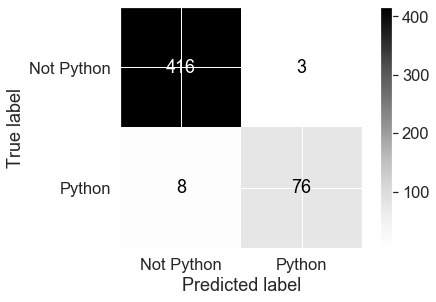

In [297]:
plot_confusion_matrix(final_nb, tf_idf_test, y_test, display_labels=['Not Python', 'Python'], cmap='Greys')

plt.tight_layout(pad=0)
# plt.savefig('images/nb_confusion.png', dpi=300)

#### Random Forest

In [291]:
final_rf = RandomForestClassifier(criterion='gini', max_depth=1, max_features=1, max_leaf_nodes=2, n_estimators=20)
final_rf.fit(tf_idf_train, y_train)

final_rf_pred = final_rf.predict(tf_idf_test)
print('Random Forest Accuracy Score: ',accuracy_score(y_test, final_rf_pred))
print('Random Forest F1 Score: ',f1_score(y_test, final_rf_pred))

Random Forest Accuracy Score:  0.8330019880715706
Random Forest F1 Score:  0.0


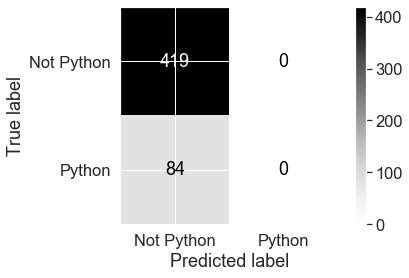

In [300]:
plot_confusion_matrix(final_rf, tf_idf_test, y_test, display_labels=['Not Python', 'Python'], cmap='Greys')
# plt.savefig('images/rf_confusion.png', dpi=200)

#### Unbalanced XGBoost

In [268]:
final_xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200)
final_xgb.fit(tf_idf_train, y_train)

final_xgb_pred = final_xgb.predict(tf_idf_test)
print('XGBoost Accuracy Score: ',accuracy_score(y_test, final_xgb_pred))
print('XGBoost Recall Score: ',recall_score(y_test, final_xgb_pred))

XGBoost Accuracy Score:  0.8886679920477137
XGBoost Recall Score:  0.6547619047619048


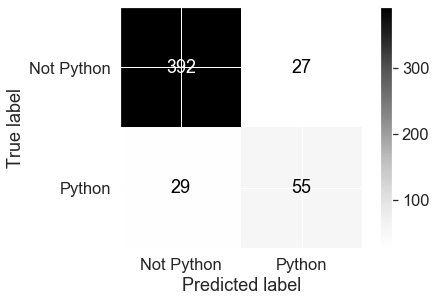

In [298]:
plot_confusion_matrix(final_xgb, tf_idf_test, y_test, display_labels=['Not Python', 'Python'], cmap='Greys')

plt.tight_layout(pad=0)
# plt.savefig('images/xgb_confusion.png', dpi=200)

#### Balanaced XGBoost

In [272]:
final_xgb_bal = xgb.XGBClassifier(learning_rate=0.0001, max_depth=5, min_child_weight=0.01, n_estimators=100)
final_xgb_bal.fit(X_train_ada, y_train_ada)

final_xgb_bal_pred = final_xgb_bal.predict(tf_idf_test)
print('XGBoost Accuracy Score: ',accuracy_score(y_test, final_xgb_bal_pred))
print('XGBoost Recall Score: ',recall_score(y_test, final_xgb_bal_pred))

XGBoost Accuracy Score:  0.8429423459244533
XGBoost Recall Score:  0.7976190476190477


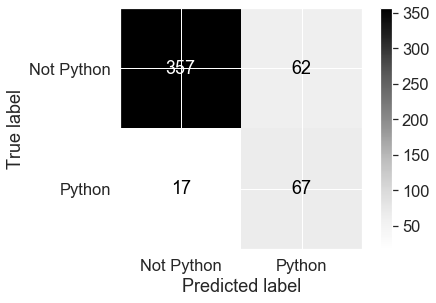

In [299]:
plot_confusion_matrix(final_xgb_bal, tf_idf_test, y_test, display_labels=['Not Python', 'Python'], cmap='Greys')

plt.tight_layout(pad=0)
# plt.savefig('images/balanced_xgb_confusion.png', dpi=200)